<a href="https://colab.research.google.com/github/namoshi/random_labels/blob/main/CNN_cifar10-randomlabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network (CNN)

Image Classification (CIAR-10) by CNN

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [10]:
# load CIFAR-10 data
train_dataset = dsets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ]))

test_dataset = dsets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ]))

#print(len(train_Dataset))

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_dataset,   # 分割するデータセット
      [40000, 10000])  # 分割数
 
print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))



Files already downloaded and verified
Files already downloaded and verified
train_dataset =  40000
valid_dataset =  10000
test_dataset =  10000


In [11]:
# Set up DataLoader
batch=128

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch,
        shuffle=True
    )

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch,
        shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch,
        shuffle=True
    )


In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*8*8, 128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)

cuda
Network architecture for CNN
 Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.001)


In [14]:
# Define Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
 

In [15]:
import numpy as np

noise_p = 0.1

def random_labels(labels, noise_p):
    s = np.random.default_rng().uniform(0,1,len(labels))
    indx = (s >= (1.0 - noise_p))
#    print(indx)

#    print(labels)
#    print(labels[indx])
    new_labels = labels.detach().numpy().copy()
#    print(new_labels[indx])
#    print(len(new_labels[indx]))
    new_labels[indx] = np.random.randint(0,9,len(new_labels[indx]))
    new_labels = torch.from_numpy(new_labels).clone()
#    print(new_labels)
#    print(new_labels == labels)

    return new_labels

In [16]:
###  training
print ('training start ...')
num_epochs = 50   

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        randlabels = random_labels(labels, 1.0)
        images, randlabels = images.to(device), randlabels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, randlabels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...
Epoch [1/50] train Loss: 0.0200, train acc: 0.1001 | val_loss: 0.0202, val_acc: 0.0998
Epoch [2/50] train Loss: 0.0205, train acc: 0.0898 | val_loss: 0.0207, val_acc: 0.0899
Epoch [3/50] train Loss: 0.0203, train acc: 0.1005 | val_loss: 0.0206, val_acc: 0.0981
Epoch [4/50] train Loss: 0.0204, train acc: 0.1004 | val_loss: 0.0206, val_acc: 0.0981
Epoch [5/50] train Loss: 0.0205, train acc: 0.0994 | val_loss: 0.0208, val_acc: 0.1025
Epoch [6/50] train Loss: 0.0205, train acc: 0.1003 | val_loss: 0.0208, val_acc: 0.0988
Epoch [7/50] train Loss: 0.0205, train acc: 0.1002 | val_loss: 0.0207, val_acc: 0.0996
Epoch [8/50] train Loss: 0.0202, train acc: 0.1003 | val_loss: 0.0204, val_acc: 0.0988
Epoch [9/50] train Loss: 0.0205, train acc: 0.0952 | val_loss: 0.0207, val_acc: 0.0989
Epoch [10/50] train Loss: 0.0208, train acc: 0.0994 | val_loss: 0.0211, val_acc: 0.1019
Epoch [11/50] train Loss: 0.0209, train acc: 0.1002 | val_loss: 0.0212, val_acc: 0.0989
Epoch [12/50] train Lo

In [17]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 10.0 %


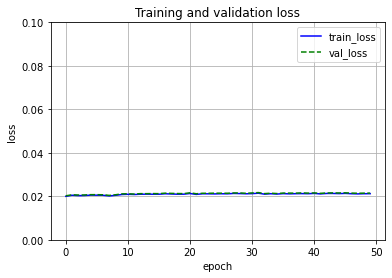

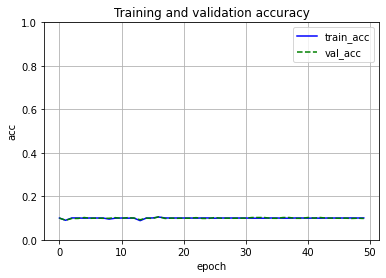

In [18]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.1])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_cifar10_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_cifar10_acc.png')
plt.show()